In [2]:
import sys
import os
import cv2
import json
from operator import *
from functools import *
from itertools import *
import numpy as np
import math
from darwinutils.fn import *
from labelme.utils import *
import imutils

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
f_expand = f_compose_r(
    os.path.expanduser,
    os.path.expandvars,
)

In [4]:
work_dir = f_expand("~/workspace/opencv-practice/face-detection")
if work_dir not in sys.path:
    sys.path.append(work_dir)

In [8]:
def load_labeled_img(img_path: str):
    with open(img_path, "r") as fd:
        img_data = json.load(fd)
    return f_compose_r(
        # f_dict_filter_func_per_AOI_keys,
        f_group(
            f_compose_r(
                itemgetter("imageData"),
                img_b64_to_arr,
            ),
            itemgetter(
                "imageHeight",
                "imageWidth",
            ),
            itemgetter("shapes"),
        ),
        tuple,
    )(img_data)

## 定义常用的路径、参数等变量

In [9]:
img_location = f_expand("~/Pictures/data")
assert os.path.isdir(img_location)
print(img_location)

invoice26_path = os.path.join(img_location, "origin", "done", "invoice_ - 26.json")  # -90度，水单_银联，手机原图
invoice1_path = os.path.join(img_location, "origin", "done", "invoice_ - 1.json")  # -180度，快递_各种，手机原图
train10_path = os.path.join(img_location, "origin", "train - 10.json")  # -180度，火车票，手机原图
train2_path = os.path.join(img_location, "origin", "train - 2.json")  # -180度，火车票，手机原图

/u/fuzhiwen/Pictures/data


In [10]:
img_data, img_size, img_shapes = load_labeled_img(invoice1_path)
print([img_data.shape, img_size, img_shapes])

[(3024, 4032, 3), (3024, 4032), [{'label': 'kd_zt_t1', 'line_color': None, 'fill_color': None, 'points': [[1292, 1554], [303, 1521], [262, 1419], [303, 763], [298, 516], [262, 351], [1336, 377], [1365, 536]], 'shape_type': 'polygon'}, {'label': 'kd_yt_t1', 'line_color': None, 'fill_color': None, 'points': [[2595, 1571], [1527, 1566], [1509, 392], [2592, 369]], 'shape_type': 'polygon'}, {'label': 'kd_bs_t1', 'line_color': None, 'fill_color': None, 'points': [[3883, 1389], [2756, 1404], [2733, 210], [3874, 166]], 'shape_type': 'polygon'}, {'label': 'kd_yt_t2', 'line_color': None, 'fill_color': None, 'points': [[1365, 2880], [283, 2869], [315, 2489], [321, 1689], [1359, 1704], [1371, 1857]], 'shape_type': 'polygon'}, {'label': 'kd_yt_t3', 'line_color': None, 'fill_color': None, 'points': [[2627, 2948], [1695, 2910], [1530, 2874], [1533, 2330], [1524, 1863], [1512, 1727], [2609, 1716], [2615, 2374]], 'shape_type': 'polygon'}, {'label': 'kd_yt_t4', 'line_color': None, 'fill_color': None, 'p

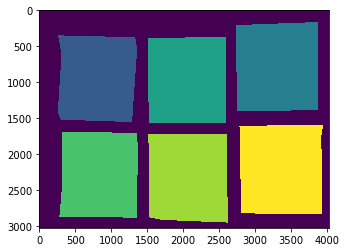

In [11]:
label_name_to_value = {
    "hc_tn": 1,
    "kd_zt_t1": 2,
    "kd_bs_t1": 3,
    "kd_yt_t1": 4,
    "kd_yt_t2": 5,
    "kd_yt_t3": 6,
    "kd_yt_t4": 7,
}
label = shapes_to_label(img_size, img_shapes, label_name_to_value)
plt.imshow(label)

'\nblurred = np.hstack([\ncv2.bilateralFilter(image, 5, 21, 21),\ncv2.bilateralFilter(image, 7, 31, 31),\ncv2.bilateralFilter(image, 9, 41, 41)])\ncv2.imshow("Bilateral", blurred)\ncv2.waitKey(0)\n'

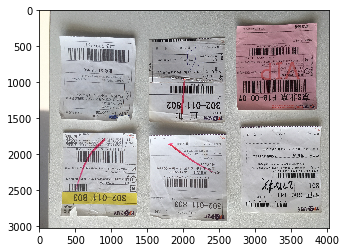

In [274]:
plt.imshow(img_data)
"""
blurred = np.hstack([
cv2.bilateralFilter(image, 5, 21, 21),
cv2.bilateralFilter(image, 7, 31, 31),
cv2.bilateralFilter(image, 9, 41, 41)])
cv2.imshow("Bilateral", blurred)
cv2.waitKey(0)
"""

## 练习 `cv2.resize`

(384, 512, 3)


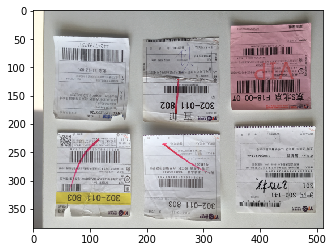

In [275]:
if True:
    img_small = imutils.resize(img_data, width=512)
else:
    h, w = img_data.shape[:2]
    r = 512.0 / w
    img_small = cv2.resize(img_data, (512, int(h*r)), interpolation=None) #cv2.INTER_AREA)
print(img_small.shape)
plt.imshow(img_small)

In [34]:
def _warp_transform(f_wrap, f_transform, m, mat=None, points=None, *args, **kwargs):
    if mat is not None:
        if len(args) == 0:
            if "dsize" not in kwargs:
                args = [mat.shape[:2][::-1]]
            else:
                args = [kwargs.pop("dsize")]
        mat = f_wrap(mat, m, *args, **kwargs)
    
    if points is not None:
        transform_kwargs = {}
        if "dst" in kwargs:
            transform_kwargs["dst"] = kwargs["dst"]
        lens = list(map(len, points))
        slices = reduce(lambda y, x: y+[slice(y[-1].stop, y[-1].stop+x)], lens, [slice(0,0)])[1:]
        print(["slices=", slices])
        points = f_compose_r(
            # expand points array
            partial(np.concatenate, axis=0),
            # reshape to satisfy f_transform
            partial(np.expand_dims, axis=1),
            # enforce type convertion to satisfy f_transform
            methodcaller("astype", np.float32),
            # fire...
            partial(f_flip_call, f_transform, m, **transform_kwargs),
            # reshape to align with normal "point"
            partial(np.squeeze, axis=1),
            # reshape to aligh with input
            partial(partial, getitem),
            partial(f_flip_call, map, slices),
            list,
        )(points)
        """
        points = f_transform(
            # -> src
            np.expand_dims(points, axis=1).astype(np.float32),
            # -> m
            m,
            # other cv2.transform() args which picked from staged "kwargs"
            **transform_kwargs,
        )
        points = list(map(f_compose_r(
            partial(f_star_call, slice),
            partial(getitem, points),
        ), zip(lens[:-1], lens[1:])))
        points = 
        """
    return mat, points

warp_affine_transform = partial(_warp_transform, cv2.warpAffine, cv2.transform)
warp_perspective_transform = partial(_warp_transform, cv2.warpPerspective, cv2.perspectiveTransform)



## 练习 画框、线、边界

(8, 2)
['rect = ', (262, 351, 1104, 1204), (262, 351), (1366, 1555)]
['center=', (801.1636352539062, 953.0848999023438)]
['size=', (1177.72021484375, 1107.1541748046875)]
['angle=', -88.61322784423828]
['pts=', array([[ 233, 1528],
       [1340, 1555],
       [1368,  377],
       [ 261,  350]], dtype=int32)]
['pt1=', array([1292, 1554], dtype=int32), array([[-1059,   -26],
       [   48,     1],
       [   76, -1177],
       [-1031, -1204]], dtype=int32)]
['distances=', array([1122157,    2305, 1391105, 2512577])]
['corner_idx=', 1]
['_angle=', -178.61322784423828]
['slices=', [slice(0, 8, None), slice(8, 9, None), slice(9, 13, None)]]
['points_translated1=', (8, 2), array([[1228., 1351.],
       [ 239., 1318.],
       [ 198., 1216.],
       [ 239.,  560.],
       [ 234.,  313.],
       [ 198.,  148.],
       [1272.,  174.],
       [1301.,  333.]], dtype=float32)]
['pts_translated', array([[ 169., 1325.],
       [1276., 1352.],
       [1304.,  174.],
       [ 197.,  147.]], dtype=float

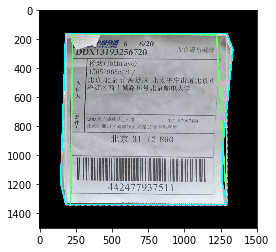

In [37]:
canvases = []
for shape in img_shapes[:6]:
    points = np.array(shape["points"], dtype=np.int32)
    print(points.shape)

    """
    # 一次fill一个polygon
    cv2.fillConvexPoly(caves, points, color=(0,100,0))

    
    # 一次draw多个polygon
    cv2.polylines(caves, [points], isClosed=True, color=(0, 255, 0), thickness=10)
    """

    
    # ###################################
    # 算bbox
    #
    rect = cv2.boundingRect(points)
    pt1 = rect[:2]
    pt2 = (pt1[0]+rect[2], pt1[1]+rect[3])
    print(["rect = ", rect, pt1, pt2])
    #cv2.rectangle(caves, pt1, pt2, color=(100, 0, 0), thickness=20)
    
    
    # ###################################
    # 算minAreaRect
    #
    center, size, angle = cv2.minAreaRect(points)
    print(["center=", center])
    print(["size=", size])
    print(["angle=", angle])
    m_rotate = cv2.getRotationMatrix2D((0, 0), angle, 1.0)[:, :2]
    m_rectangle = np.array([
        [-1, -1],
        [-1, 1],
        [1, 1],
        [1, -1],        
    ])
    pts = np.dot(np.array(size)/2.0*m_rectangle, m_rotate)+center
    pts = pts.astype(np.int32)
    print(["pts=", pts])

    
    # ###################################
    # 算偏转角(依赖之前算出的minAreaRect)
    #
    pt1 = points[0]
    distances = np.sum(np.square(pts - pt1), axis=1)
    corner_idx = np.argmin(distances)
    delta_angle = [0, -90, 180, 90]
    angle += delta_angle[corner_idx]
    print(["pt1=", pt1, pts-pt1])
    print(["distances=", distances])
    print(["corner_idx=", corner_idx])
    print(["_angle=", angle])
    
    
    # ###################################
    # 切出(crop)
    #
    mask = np.zeros(img_data.shape[:2], dtype="uint8")
    cv2.fillConvexPoly(mask, points, color=255)
    masked = cv2.bitwise_and(img_data, img_data, mask=mask)

    
    # ###################################
    # 位移(translate，拉伸画布，移动片段到画布中央)
    #
    x, y, w, h = rect  # 输入
    masked = masked  # 输入
    
    #max_width = math.ceil(math.sqrt(w**2+h**2))
    max_width = 1500
    _y, _x = (max_width - np.array([h, w])) // 2
    translated = np.zeros([max_width, max_width, masked.shape[2]], dtype="uint8")
    
    # 移动图（密集）
    # 贴入图片片段，对齐中央，省去一次cv2.translate
    translated[_y:_y+h, _x:_x+w] = masked[y:y+h, x:x+w]

    # 计算位移矩阵(only for sparse)
    m_translate = np.float32([[1, 0, _x-x], [0, 1, _y-y]])

    # 移动点（稀疏）
    _, (points_translated, (center_translated,), pts_translated) = warp_affine_transform(
        m_translate,
        points=[points, [center], pts],
    )    
    print(["points_translated1=", points_translated.shape, points_translated])
    print(["pts_translated", pts_translated])
    print(["center_translate", center_translated])

    # 画移动过的边框
    # 这个先不画了，等会旋转完了，在画最终的，以验证经过多次变换的边框还是对的。
    #cv2.polylines(translated, [points_translated.astype(np.int32)], isClosed=True, color=(255, 255, 255), thickness=10)

    # show出画布
    #plt.imshow(translated)

    
    # ###################################
    # 拉伸(stretch, 透视变换，依赖之前算出的minAreaRect)
    #
    # TODO: 这个选点的办法在偏转太大的情况下是会出错的，
    #       期望的结果是离目标rotated_rect的四个顶点最合理的四个锚点，
    #       当前只是简单计算离4个目标顶点距离最近的4个点。
    masked = translated  # 输入
    points = points_translated  # 输入
    pts = pts_translated  # 输入
    
    # 从多边形外围边界挑选4个顶点与目标stretch的rectangle顶点形成透视变换源点组
    deltas = np.stack(map(
        f_compose_r(
            partial(np.subtract, pts),
            np.square,
            partial(np.sum, axis=1),
        ),
        points,
    ))
    corner_idxes = np.argmin(deltas, axis=0).tolist()
    pts_src = np.array(itemgetter(*corner_idxes)(points))
    pts_dst = pts
    print(["deltas=", deltas.shape, deltas])
    print(["corner_idxes=", corner_idxes])
    print(["pts_src=", pts_src])
    print(["pts_dst=", pts_dst])

    # 计算透视变换矩阵
    m_stretch = cv2.getPerspectiveTransform(pts_src.astype(np.float32), pts_dst.astype(np.float32))
    print(["m_stretch=", m_stretch])
    
    # 拉伸
    stretched, (points_stretched,) = warp_perspective_transform(
        m_stretch,
        mat=masked,
        points=[points],
    )
    #print(["points_stretched=", points_stretched.shape, points_stretched])
    
    # 下面连个边框先在画布上画上去，下面还要旋转。
    cv2.polylines(stretched, [pts_src.astype(np.int32)], isClosed=True, color=(100, 255, 100), thickness=10)
    cv2.polylines(stretched, [pts_dst.astype(np.int32)], isClosed=True, color=(200, 200, 200), thickness=10)

    # show出画布
    #plt.imshow(stretched)

    
    # ###################################
    # 旋正(依赖之前算出的偏转角)
    #
    masked = stretched  # 输入
    points = points_stretched  # 输入
    center = tuple(center_translated)  # 输入
    
    # 计算仿射变换矩阵
    m_rotate = cv2.getRotationMatrix2D(center, angle, 1.0)
    print(["m_rotate=", m_stretch])
    
    # 旋转
    rotated, (points_rotated,) = warp_affine_transform(
        m_rotate,
        mat=masked,
        points=[points],
    )    
    #print(["points_rotated=", points_rotated.shape, points_rotated])
    
    # 画旋转过的边框
    # 这个会验证经过两次变换的边框，还是准确的。
    cv2.polylines(rotated, [points_rotated.astype(np.int32)], isClosed=True, color=(0, 255, 255), thickness=10)

    # show出画布
    #plt.imshow(rotated)
    
    # 导出结果到loop外
    masked = rotated
    points = points_rotated
    canvases.append(masked)

if len(canvases) > 0:
    canvas = np.concatenate(canvases, axis=1)
    print(["canvas=", canvas.shape, len(canvases)])
    plt.imshow(canvas)
    # 画的多边形线是连贯的，不信你开大图看吧。
    cv2.imwrite("/tmp/1.jpg", canvas)